# Data Generation and Analysis workshop
## Tuesday Oct 8, 2024: Simulation in-depth - Relaistic Simulation

In the course of this session we will:
1. Simulate more realistic orbits
2. Explore the noise parameters of LISA Instrument
3. Create and inject a shapelet glitch
4. Produce various TDI combinations, including Michelson XYZ and noise-orthogonal AET.

### 0. Requirements
Install and import the required packages

In [ ]:
# install via pip the required packages discussed in previous sessions
!pip install lisainstrument lisaorbits lisaglitch pytdi

In [ ]:
# requirements for the lisa-data-challenge package
!apt-get install libgsl-dev
!apt-get install libfftw3-dev
# LDC package
!pip install lisa-data-challenge

In [ ]:
# import system libraries
import logging

# import scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import h5py

In [ ]:
# set logging level to INFO (more verbose and informative)
logging.basicConfig(level=logging.INFO)
logging.getLogger("lisainstrument").setLevel(logging.INFO)

#### 0.1 Sampling and time grids

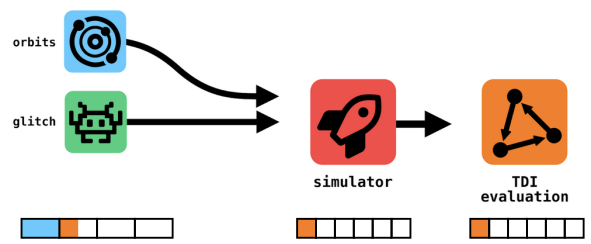

Before we start, a note about the sampling parameters we will simulate.

We usually want to simulate samples regularly space, and attached to a given time grid. Three quantities are necessary to define the grid: an initial time `t0`, a sampling time `dt`, and a number of samples `size`. We then have

```python
t = t0 + np.arange(size) * dt
```

This time window logically spans `size * dt` seconds.

If we want to simulate TDI combinations (computed with PyTDI) on a given time grid, say `(t0, size, dt)`, we need to think about the time grids to use for LISA Instrument, LISA Orbits, any injected GW signals (for example, using LISA GW Response), and any glitches injected with LISA Glitch.

1. To avoid edge effects, we need to trim some samples returned by **PyTDI**. This is because, internally, PyTDI uses some digital fractional delay filters to compute the TDI combinations. Say we trim `pytdi_trim = 1000` samples; this means we need a time grid of `(t0 - pytdi_trim * dt, size + pytdi_trim, dt)` as input for PyTDI.

2. In principle, we also need to trim the beatnote measurements we get from **LISA Instrument**. However, we can be smart and let PyTDI initialize itself with these samples, such that `pytdi_trim` discards PyTDI *and* LISA Instrument burn in.

  So we request `(t0 - pytdi_trim * dt, size + pytdi_trim, dt)` from LISA Instrument.

3. Let's think about orbits information needed by LISA Instrument (from **LISA Orbits**): we need the light travel times and spacecraft positions on the same grid `(t0 - pytdi_trim * dt, size + pytdi_trim, dt)`. But that's not all: laser beams are emitted by the emitter spacecraft ~8 seconds before they are received and measured. So we need the position of the emitting spacecraft ~8 seconds before our beatnote measurement grid start. In addition, there might be onboard clock offsets, such that a time `t0 - pytdi_trim * dt` on the clock might correspond to a smaller time value in the Solar system time grame. For good measure, let's allow for a margin of `orbits_trim = 100` samples.

  Orbital quantities are slowly varying, and so we usually use a much lower sampling rate (ie, a larger `dt`). Let's use the default value provided by LISA Orbits `orbits_dt = dt=100000`. Overall, we need `(t0 - pytdi_trim * dt - orbits_trim * orbits_dt, (size + pytdi_trim + orbits_trim) * dt / orbits_dt, orbits_dt)`.

4. Turning now to **LISA Glitch**. LISA Instrument interpolates or extrapolates the glitch signals to match the requested time grid. So, as long as the glitch time grid is covered by the LISA Instrument grid, we're good.

  As a convenience, we use the exact same time grid (no interpolation nor extrapolation): `(t0 - pytdi_trim * dt, 4 * (size + pytdi_trim), dt / 4)`. The sampling rate is 4 times higher, because internally, LISA Instrument simulates the physics at a higher rate.

5. In this session, we won't inject any signals. If you do, keep in mind that you need the GW response computed on the same grid as LISA Instrument. The response is often computed from strain time series ($h_+, h_\times$) expressed at the Sun. Depending on the position of the source $k$ and the constellation $r$, you might have a delay of $k \cdot r \over c$, which is at most 1 au / c. Remember to allow for such a margin when defining your strain time grid.

In [ ]:
dt = 0.25 # s
size = 90_000 # samples
t0 = 2173211130.0 # s

print("Simulation duration:", size * dt / 3600, "h")

In [ ]:
pytdi_trim = 1000
pytdi_t0 = t0 - pytdi_trim * dt
pytdi_size = size + pytdi_trim

instrument_t0 = pytdi_t0
instrument_size = pytdi_size

glitch_dt = dt / 4
glitch_t0 = instrument_t0
glitch_size = 4 * instrument_size

orbits_dt = 100_000
orbits_trim = 100
orbits_t0 = t0 - pytdi_trim * dt - orbits_trim * orbits_dt
orbits_size = np.ceil(3600 * 24 * 365 / orbits_dt) # a year, for illustration purposes

### 1. Realistic Orbits

LISA Orbits is
also capable of simulating more realistic orbits for the LISA constellation.

Here, we want to move away from `EqualArmlengthOrbits` and try out
`KeplerianOrbits` and numerical OEM (Orbit Ephemeris Message) files.

📚 [LISA Orbits documentation](https://lisa-simulation.pages.in2p3.fr/orbits/html/v2.4.2/index.html)

In [ ]:
from lisaorbits import KeplerianOrbits, OEMOrbits

#### 1.1 Keplerian Orbits

Keplerian orbits are analytical orbits that can be calculated from a closed-form
expression (see
[here](https://lisa-simulation.pages.in2p3.fr/orbits/html/v2.4.2/keplerian.html)).
They are solutions of the two-body problem, expanded to second-to-leading order
in eccentricity. Each spacecraft is revolving around the sun on its own Kepler
ellipse which makes arms slightly time-varying.

We can instantiate an `KeplerianOrbits` object by calling `orbits =
KeplerianOrbits()`.

In [ ]:
orbits = KeplerianOrbits()

✅ Use the convenience functions `orbits.plot_spacecraft(t_orbits, sc)` and `orbits.plot_links(t_orbits)` to plot quantities related to the spacecraft and related to the links. Construct the time vector `t_orbits` yourself spanning 1 year.

📚 Find the definition of all quantities in the [docs](https://lisa-simulation.pages.in2p3.fr/orbits/html/latest/model.html).

#### 1.2 ESA Orbits

We all know that the Solar system is a bit more complicated than what Kepler
observed with his small telescope. The gravitational pull of the earth and other
planets will influence the spacecraft orbits which deviate from closed ellipses
rather quickly. Thus, orbits need to be integrated numerically and luckily ESA
provides us readily with the results (see
[GitHub](https://github.com/esa/lisa-orbit-files)).

There is a easy-to-use interface in LISA Orbits to instantiate an `OEMOrbits` object by calling `esa_orbits = OEMOrbits.from_included('esa-trailing')`.

In [ ]:
orbits = OEMOrbits.from_included("esa-trailing")

✅ Repeat the exercise from above. Keep in mind that start and end time of the numerical orbit file dictate where we can evaluate it, so we abandon our neatly crafted time grid and follow ESA's.

Check out the parameters `t_start` and `t_end` to figure out the coverage and define `t_orbits` accordingly. Don't forget to trucate the edges by `orbits_trim` samples to make sure you only evaluate the orbits inside the domain.

✅ Lastly, write your favorite orbits to disk by calling the `orbits.write()` method for later.

✅ To see [what is inside an orbit
file](https://lisa-simulation.pages.in2p3.fr/orbits/html/v2.4.2/file.html), open
the h5py file using a context manager and explore its content as

```python
with h5py.File("orbits.h5", "r") as hdf5:
    print("Groups:", list(hdf5.keys()))
    print("Attributes:", dict(hdf5.attrs))
    print("Datasets in 'tcb':", list(hdf5["tcb"].keys()))
    print("TCB LTTs:", hdf5["tcb"]["ltt"][:])
    # ...
```

📚 [Documentation of an orbit file](https://lisa-simulation.pages.in2p3.fr/orbits/html/v2.4.2/file.html)

### 2. Instrumental Noise

The `lisainstrument` package documentation is available in the [code](https://gitlab.in2p3.fr/lisa-simulation/instrument) or in the reference paper [Bayle and Hartwig](https://link.aps.org/doi/10.1103/PhysRevD.107.083019).

📚 [Bayle and Hartwig](https://link.aps.org/doi/10.1103/PhysRevD.107.083019)

The main purpose of LISA Instrument is to simulate various instrumental noises and amalgamate them with GW signals. The noise levels and shapes can be controlled via the `Instrument()` constructor or altered after instantiation. Check out the [code](https://gitlab.in2p3.fr/lisa-simulation/instrument/-/blob/master/lisainstrument/instrument.py?ref_type=heads#L62) for a comprehensive list of noise parameters that are available.

List of instrumental noise sources implemented in LISA Instrument:
- Laser frequency noise: instability of the laser's central frequency
- Modulation noise: additive noise in the sideband modulation of the lasers
- Clock noise: frequency instability of the on board ultra stable oscillators
- Backlink noise: fiber noise introduced in the backlink fiber
- Test mass acceleration noise: spurious acceleration on the test mass due to resiudal gas pressure
- OMS noise: umbrella term for noises entering on the Optical Metrology System, e.g. readout noise
- angular jitters: angular jitter of MOSAs/SCs causing TTL (tilt-to-length) coupling
- DWS noise: readout noise of the Differential Wavefront Sensing sensors
- ranging noise: uncertainty of the PRN (pseudo-random noise) ranging sensors

Noise parameter can be set via the constructor either by providing a single value (applies to all MOSAs/SCs) or as a dictionary to set unequal values for each MOSA/SC. For example:

```python
instr = Instrument(laser_asds=30)
```

or

```python
laser_asds = {
    '12': 30, '23': 40, '31': 50,
    '13': 60, '32': 70, '21': 80
}

instr = Instrument(laser_asds=laser_asds)
```

An important convenience function is the `disable_all_noises(excluding=...)` which can be used as a noise switch after instantiation to turn off all noises except those listed in the `excluding` parameter (which can be a single string or a list of strings).

In [ ]:
from lisainstrument import Instrument

✅ Instantiate an `Instrument` object to prepare for a simulation specified above by adjusting the `size` and `t0` parameter. Also set the `orbits` parameter to the previously generated `'orbits.h5'`. Set individual levels for the OMS ASD `oms_asds` for the inter-spacecraft interferometer.

Hint: The `oms_asds` parameter is provided as a 6-tuple that specifies the levels for the various interferometers hosted on each MOSA. The first entry specifies the levels for the inter-spacecraft interferometer (carrier).

✅ Run a simulation by running the `instr.simulate()` method of the `Instrument` class with no arguments.

✅ Plot the different beatnote frequency fluctuations and see if you can observe a difference in the noise levels across MOSAs.

✅ Run a laser-noise-only simulation using the same `size` and `orbits` and write it to file with the `instr.write('laser-noise-only.h5', mode='w')` method for later.

#### Bonus task: 2.1 Laser Locking

##### 2.1.1 Run simulation with realistic orbits and default noise configuration

By default, the simulation is performed with all instrumental noises enabled with default values based on the perfomance model (warning: some noises are not up to date, or have simplified models).

✅ Instantiate another `Instrument` object and use `lock='six'` to disable laser locking (this will produce uncorrelated laser noises) and `laser_shape='white'` for a white laser noise spectrum.

✅ Run a simulation by running the `instr.simulate()` method of the `Instrument` class with no arguments.

✅ Plot the time series and spectrum of the beatnote frequency fluctuations. Use the `plot_fluctuations` convenience function and `scipy.signal.welch` to do so. The time-series data can be accessed though `instr.isi_carrier_fluctuations`, `instr.rfi_carrier_fluctuations` and `instr.tmi_carrier_fluctuations`.

##### 2.1.2 Run simulation with locked lasers

In reality the six lasers will not run indepent to each other. The LISA mission requires beatnote frequencies of 5-25 MHz and to ensure this the lasers are locked to each other. As a consequence five of the six lasers "follow" or "copy" the noise of the primary laser. Let us now observe the effect of laser locking.

✅ Instantiate a new `Instrument` object and change `lock='six'` to `lock='N1-12'`. This will configure the locking topology `N1` and set Laser `L12` as the primary laser.

✅ Run the simulation and write it to file.

✅ Replot the time series and spectrum of the beatnote frequency fluctuations. What do you observe in comparison to the unlocked case?

### 3. TDI combinations

PyTDI is a Python package that can be used to perform symbolical and numerical TDI calculations. The package also provides you with the most commonly-used [standard combinations](https://lisa.pages.in2p3.fr/LDPG/wg6_inrep/pytdi/master/standard-combinations.html), e.g. Michelson, Sagnac and quasi-orthogonal combinations.

📚 [PyTDI documentation](https://lisa.pages.in2p3.fr/LDPG/wg6_inrep/pytdi/master/)

Calculating a TDI combination involves three steps:
1. Loading data: to do so you can choose between various [convenience functions](https://lisa.pages.in2p3.fr/LDPG/wg6_inrep/pytdi/master/interface.html) provided by the `Data` class that interfaces to other LISA simulation tools, i.e. LISA Orbits, LISA GW Response, LISA Glitch, LISANode and LISA Instrument
2. Building the combination: Before evaluating a combination we need to build it first. This step prepares the nested time-delays required to shift the data. Simply call `build(**data.args)` on your combination providing the `data` that you have loaded in the previous step.
3. Evaluating the combination: The final step is evaluating the combination. This is done by calling the built combination providing the beatnote frequencies.

In [ ]:
from pytdi.michelson import X1, X2
from pytdi import Data
from ldc.lisa.noise import get_noise_model

✅ Calculate first and second generation Michelson X for the laser-noise-only dataset from above (realistic orbits).

✅ Calculate the spectra for both time series using SciPy's `welch` function as introduced yesterday.

Hint: Truncate the first 1000 samples (using the variable `tdi_trim`) of the tdi time series before calculating the spectra as the first samples are invalid.

✅ Plot the two spectra and compare them with the noise model from the LDC package (see yesterday's notebook). Call `LISAnoisemodel.psd` for both `tdi2=False` and `tdi2=True` to get representative curves for first and second generation Michelson combinations.

✅ Bonus task: do the same for A, E and T

In [ ]:
from pytdi.ortho import T1, T2

### 4. Glitches

We've already installed LISA Glitch with pip.

📚 The `lisaglitch` package documentation is available [here](https://lisa-simulation.pages.in2p3.fr/glitch/v1.3/).

#### 4.1 Create the glitch

From `lisaglitch` import the class `IntegratedShapeletGlitch`, which is going to inject a glitch in fractional frequency deviations.

📚 [Documentation for `IntegratedShapeletGlitch`](https://lisa-simulation.pages.in2p3.fr/glitch/v1.3/lpf.html#integrated-shapelet)

The `IntegratedShapeletGlitch` class is based on the model described in [this paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.105.042002).

In [ ]:
from lisaglitch import IntegratedShapeletGlitch

✅ Then define a set of uniformly and log-uniformly distributed parameters following the rules here below:
* ✅ import `uniform` and `loguniform` from `scipy.stats` to sample from a uniform and log-uniform distribution using the method `.rvs(lower_bound, upper_bound)`
* ✅ import `random` to randomly choose between the injection points using the `random.choice()` method.

📚 [Documentation for `scipy.stats.uniform`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html)

📚 [Documentation for `random.choice()`](https://docs.python.org/3/library/random.html#random.choice)

✅ Create an instance of `IntegratedShapeletGlitch` with a set of more-or-less realistic parameters for LISA Pathfinder glitches, i.e.:
* an amplitude `level` uniformly distributed between $10^{-13}$ and $10^{-9}$ m/s **check lower and upper boundaries**
* a damping time `beta` log-uniformly distributed between $0.01$ and $100$ s
* an injection point `inj_point` chosen among the test-mass injection points `'tm_12'`, `'tm_13'`, `'tm_21'`, `'tm_31'`
* an injection time `t_inj` chosen between the start and the end of the glitch simulation

Note that the units associated with the glitch signal depends on the injection point. The documentation of the available injection points gives that information.

📚 [Documentation for LISA Glitch's injection points](https://lisa-simulation.pages.in2p3.fr/glitch/v1.3/injpoints.html)

✅ Print the injected glitch parameters by accessing the `glitch` instance attributes: `.level`, `.beta`, `.inj_point`, `.t_inj`

✅ Define a time vector `glitch_t` that follows the discussed glitch time grid

✅ Plot the glitch using the `.plot(t)` method


✅ Write the glitch to file using the `.write()` method
* ✅ pass the time vector `t` information as keyword arguments to the `.write()` method: `t0`, `size` and `dt`

#### 4.2 Pass the glitch file to `Instrument`

✅ Pass the glitch file to the `Instrument` object as an external file `glitches`. Use the same settings we used in yesterday's simulation: disable all noises via `.disable_all_noises()` and exclude `'laser'`, `'test-mass'`, `'oms'`

✅ Run the instrumental simulation using `.simulate()`

✅ Write it to file using `.write("simulation-noise-glitches.h5"`

✅ Plot the beatnote frequency fluctuations and see if you can observe the glitch.

✅ Setup another simulation without the glitch, but only noise. Write it to file using `.write("simulation-noise.h5")`

#### 4.3 Evaluate and plot the TDI combinations

✅ Evaluate and plot the TDI combinations for the noise + glitches simulation

✅ Evaluate and plot the TDI combinations for the only glitches simulation

Hint: don't forget to rescale correctly the resulting TDI combinations to convert from Hz to strain.

In [ ]:
from pytdi import Data
from pytdi.michelson import X2, Y2, Z2

#### 4.4 Frequency domain
✅ Evaluate and plot the power spectra of the noise + glitches and glitches simulations